In [1]:
import numpy as np
import pandas as pd
import pyarrow
import fastparquet
from pandasql import sqldf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import string

/Users/isabellajohansson/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


cluster out transfer vs income, ( - cosine similarity, high-frequency vs low frequency name:

<h1><font color='green'>1. Segment the users into segments that represent the ways that a users is paid. For instance bi-weekly vs pension vs gig economy. Ensure that you can model a user with multiple income streams. Please provide an example segmentation
    </font></h1>

In [2]:
#Data pre processing:
transactions = pd.read_parquet("data_science_take_home_transactions.parquet", engine='pyarrow')
advances = pd.read_parquet("data_science_take_home_advances.parquet", engine='pyarrow')

###1. Convert 'account_id' to numerical values
# Create a copy of the 'account_id' column as 'account_id_string'
transactions['account_id_string'] = transactions['account_id'].copy()
advances['account_id_string'] = advances['account_id'].copy()

label_encoder = LabelEncoder() # Create a label encoder object

transactions['account_id'] = label_encoder.fit_transform(transactions['account_id']) # Transform 'account_id' column to numerical values and replace the original column 
advances['account_id'] = label_encoder.fit_transform(advances['account_id'])

###2. Only looking at postivie numbers and ignoring charges (for now?).
#Noticed that for payment_channel: "online" and "in-store" can be filtered out bc they seem to exclude salaries.
selected_data = transactions[(transactions['payment_channel'] != 'online') &
                             (transactions['payment_channel'] != 'in store') &
                             (transactions['f0_'] > 0)]
###3. Lets ignore irrelevant columns: 

columns_to_remove = ['version', 'currency_code', 'pending', 'removed', 'selected_data', 'city', 'region', 'payment_meta_payment_processor',
                    'authorized_date', 'payment_meta_payment_method', 'payment_channel']
cleaned_data = selected_data.drop(columns=columns_to_remove, axis=1, errors='ignore')

# Let's ensure the 'date' column is converted to a datetime format before using the .dt accessor. 
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])

# Feature Engineering: Extract features from dates and descriptions
cleaned_data['day_of_week'] = cleaned_data['date'].dt.dayofweek
cleaned_data['week_number'] = cleaned_data['date'].dt.isocalendar().week
cleaned_data['month'] = cleaned_data['date'].dt.month

cleaned_data

,account_id,id,f0_,date,name,bank_account_id,account_id_string,day_of_week,week_number,month
4,1665,bQjKpjODw8cLVEZB6kD9fez4dN04ZQs9nVoz0,54.18,2021-11-24,"VISA TRANSFER, *****30100057355, AUT 112321 VI...",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,2,47,11
11,1665,Q87Qp7vXkJTxJjQZb97NtaMyELjyQDTJ85MxQ,200.00,2021-11-10,"ATM CASH DEPOSIT, *****3010005735",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,2,45,11
14,1665,9589X8gvxATeNg3rY0pJhVjgoVOQ3niy1L4KL,60.00,2022-09-01,"ACH DEPOSIT, WISELY ACH P2PTRANSFR 8683261 J ROM",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,3,35,9
16,1665,J04Op4qv1Ji873Ej6YVpIN0DeNkjmdskyavoX,1135.21,2022-09-23,"ACH DEPOSIT, CTC ACADEMY INC DIRECT DEP ****85...",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,4,38,9
18,1665,XEoMpoJnX8t9bZqVMwOBsjxpQ73pq9i6EDyDD,300.00,2022-03-01,"ATM CASH DEPOSIT, *****3010005735",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,1,9,3
...,...,...,...,...,...,...,...,...,...,...
1962474,1201,4pne03LZwphYQDoBPNOySXj5AVeB8VC1vAw40,92.00,2022-10-21,Zayzoon Payout CHEYENNE WY 125560 10/2,Dzx6EBa4mziyMXKjV0ZxSngk5QNXJzHgx9jZK,kv8gyng97yyg2,4,42,10
1962475,1201,Jz1BNvo4Lzij8J6QMdkri5kYZLx0aLIAe9jno,94.00,2022-09-02,Zayzoon Payout CHEYENNE WY 153665 09/0,Dzx6EBa4mziyMXKjV0ZxSngk5QNXJzHgx9jZK,kv8gyng97yyg2,4,35,9
1962476,1201,XzXPRnNowziV9LMxp308H56PqVoxyVIO3rRZq,94.00,2022-09-30,Zayzoon Payout CHEYENNE WY 207757 09/3,Dzx6EBa4mziyMXKjV0ZxSngk5QNXJzHgx9jZK,kv8gyng97yyg2,4,39,9
1962477,1201,6pe4EK17LphMrwY67NQ0uoM90xJOXxiV40P84,84.00,2022-12-02,Zayzoon Payout CHEYENNE WY 455830 12/0,Dzx6EBa4mziyMXKjV0ZxSngk5QNXJzHgx9jZK,kv8gyng97yyg2,4,48,12


### Example of segmentation:
#### 1. Transaction Type Identification: Categorize transactions that represent income (like direct deposits, salary payments, pension deposits, gig economy)payments, etc.). You might use keywords, transaction types, or specific account references to identify these transactions.

#### or 2. Use a machine learning approach using a Decision Tree Classifier to predict salary transactions based on features extracted from dates, amounts, and transaction descriptions....Adjust and expand upon this framework based on your specific data and requirements for categorizing salary and non-salary transactions. 

In [3]:
# 1. Define keywords or phrases that indicate different income sources -- 
### NEED TO ADD A LOT MORE KEY-WORDS HERE..this takes a lot of manual work ..time consuming

salary_keywords = ['salary', 'paycheck', 'wage', 'payroll']
pension_keywords = ['pension', 'retirement']
gig_keywords = ['gig', 'lyft', 'uber', 'zelle']
non_income_keywords = ['transfer', 'visa', 'atm','transfer']

def categorize_transaction(row):
    name = row['name'].lower()
    if any(keyword in name for keyword in salary_keywords):
        return 'Salary'
    elif any(keyword in name for keyword in pension_keywords):
        return 'Pension'
    elif any(keyword in name for keyword in gig_keywords):
        return 'Gig Economy'
    elif any(keyword in name for keyword in non_income_keywords):  # Check for 'Non-Income' keywords
        return 'Non-Income'  # Assign 'Non-Income' category for transactions with specified keywords
    else:
        return 'Non-Income'  # Default to 'Non-Income' for other non-matching transactions

# Apply categorization function to create a new 'transaction_category' column
cleaned_data['transaction_category'] = cleaned_data.apply(categorize_transaction, axis=1)

# Display the segmented data
cleaned_data[0:10]

,account_id,id,f0_,date,name,bank_account_id,account_id_string,day_of_week,week_number,month,transaction_category
4,1665,bQjKpjODw8cLVEZB6kD9fez4dN04ZQs9nVoz0,54.18,2021-11-24,"VISA TRANSFER, *****30100057355, AUT 112321 VI...",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,2,47,11,Non-Income
11,1665,Q87Qp7vXkJTxJjQZb97NtaMyELjyQDTJ85MxQ,200.00,2021-11-10,"ATM CASH DEPOSIT, *****3010005735",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,2,45,11,Non-Income
14,1665,9589X8gvxATeNg3rY0pJhVjgoVOQ3niy1L4KL,60.00,2022-09-01,"ACH DEPOSIT, WISELY ACH P2PTRANSFR 8683261 J ROM",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,3,35,9,Non-Income
16,1665,J04Op4qv1Ji873Ej6YVpIN0DeNkjmdskyavoX,1135.21,2022-09-23,"ACH DEPOSIT, CTC ACADEMY INC DIRECT DEP ****85...",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,4,38,9,Non-Income
18,1665,XEoMpoJnX8t9bZqVMwOBsjxpQ73pq9i6EDyDD,300.00,2022-03-01,"ATM CASH DEPOSIT, *****3010005735",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,1,9,3,Non-Income
19,1665,nnrDNrPjA4ioerJ0qXd8udLq6dBzMpT7zYN0v,25.00,2022-05-26,"ACH DEPOSIT, WISELY ACH P2PTRANSFR 7646515 J ROM",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,3,21,5,Non-Income
22,1665,epbKObRqDMT0eXO1MQq7f7Kvb70VJrfaBP7Ay,100.00,2022-10-04,"VISA TRANSFER, *****30100057355, AUT 100422 VI...",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,1,40,10,Non-Income
26,1665,VExApxanXQt1rJv7dP40hp3LrQeLv1SkVdYdM,50.00,2022-02-17,"ATM CASH DEPOSIT, *****3010005735",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,3,7,2,Non-Income
32,1665,gEjAOjn3P8tEegrP3wRaun7o7dVN8xuAJvAAz,100.00,2022-11-09,WISELY ACH P2PTRANSF,00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,2,45,11,Non-Income
37,1665,xME9bEj7rwCBV1ZdEny9Tp0EdpOABaTod5QrK,45.00,2022-09-22,"VISA TRANSFER, *****30100057355, AUT 092222 VI...",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,3,38,9,Non-Income


In [4]:
# 2. Extract features from dates and descriptions
cleaned_data['day_of_week'] = cleaned_data['date'].dt.dayofweek
cleaned_data['week_number'] = cleaned_data['date'].dt.isocalendar().week
cleaned_data['month'] = cleaned_data['date'].dt.month

# Define keywords for salary income types (bi-weekly, monthly, gig)
salary_keywords = ['salary', 'paycheck', 'monthly', 'bi-weekly']  # Update as needed

# Create a binary label for salary transactions based on keywords in 'name'
cleaned_data['is_salary'] = cleaned_data['name'].apply(lambda x: any(keyword in x.lower() for keyword in salary_keywords)).astype(int)

# Features for classification (example; update as needed)
features = ['day_of_week', 'week_number', 'month', 'f0_']  # Add or modify features

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(cleaned_data[features], cleaned_data['is_salary'], test_size=0.2, random_state=42)

# Train a decision tree classifier (you can use a different model)
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on test set
predictions = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.9926163769325431


#### A model accuracy of approximately 99.26% indicates that the Decision Tree Classifier performed exceptionally well on the test data. This high accuracy could be due to various reasons: 
A model accuracy of approximately 99.26% indicates that the Decision Tree Classifier performed exceptionally well on the test data. This high accuracy could be due to various reasons:

Possible Reasons for High Accuracy:
Distinct Patterns: The features extracted from transaction dates, amounts, and descriptions might have distinct patterns that distinguish salary transactions from non-salary ones.

Clear Discrimination: The keywords used to identify salary transactions ('salary', 'paycheck', 'monthly', 'bi-weekly') could effectively differentiate between income types.

Sufficient Data: The dataset might have a substantial amount of diverse and representative data, enabling the model to learn and generalize well.

### Further Steps:
- Despite the high accuracy, it's crucial to perform further analysis and steps to ensure the model's robustness and reliability:

- Validation: Validate the model using cross-validation or on an entirely separate validation dataset to confirm its generalization ability.

- Feature Importance: Assess feature importance to understand which features contribute most to the classification.

- Model Evaluation Metrics: Consider using metrics beyond accuracy (e.g., precision, recall, F1-score) to evaluate the model's performance, especially if the dataset is imbalanced.

- Error Analysis: Investigate misclassified samples to understand why certain transactions were mislabeled and if any patterns were overlooked.

- Refinement: Fine-tune the model, adjust hyperparameters, or experiment with different algorithms to improve its performance further.


/Users/isabellajohansson/miniconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


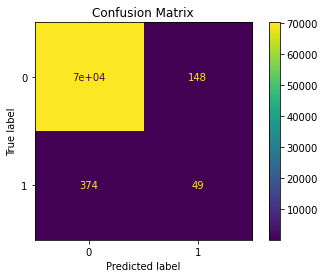

In [5]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(model, X_test, y_test)
plt.title('Confusion Matrix')
plt.show()

In [6]:
# Group data by account_id and 'name' (transaction description)
grouped_data = cleaned_data.groupby(['account_id', 'name'])

# Analyze time intervals between transactions for each account
# Calculate average time intervals to identify patterns
# Analyze transaction descriptions for keywords indicating gig, bi-weekly, or monthly payments

# Based on patterns identified:
# Create new columns or labels to categorize transactions as 'gig', 'bi-weekly', 'monthly', etc.

# For example, if 'gig', 'bi-weekly', and 'monthly' are identified categories:
# Use conditions and keywords to categorize transactions
cleaned_data['income_type'] = 'Other'  # Initialize as 'Other'
cleaned_data.loc[cleaned_data['is_salary'] == 1, 'income_type'] = 'Monthly'  # Assign default as 'Monthly'

# Identify bi-weekly or gig payments based on patterns or keywords in 'name' column
# Update 'income_type' accordingly
# cleaned_data.loc[(conditions_for_biweekly), 'income_type'] = 'Bi-weekly'
# cleaned_data.loc[(conditions_for_gig), 'income_type'] = 'Gig'

# View the categorized salary transactions
salary_transactions_categorized = cleaned_data[cleaned_data['is_salary'] == 1]
salary_transactions_categorized[['account_id', 'name', 'income_type']]


,account_id,name,income_type
696,1371,Salary/Regular Income from Raiser LLC,Monthly
751,1371,Salary/Regular Income from StanleyBlackAndDecker,Monthly
798,1371,Salary/Regular Income from StanleyBlackAndDecker,Monthly
799,1371,Salary/Regular Income from StanleyBlackAndDecker,Monthly
1845,130,Monthly Maintenance Fee Waive,Monthly
...,...,...,...
1927380,1188,OneBlinc Salar 12/18 #XXXXX1733 PMNT RCVD OneB...,Monthly
1938358,1722,TYPE: FED SALARY ID: 3091036122CO: MPLS USPS P...,Monthly
1938359,1722,TYPE: FED SALARY ID: 3091036122CO: MPLS USPS P...,Monthly
1938360,1722,TYPE: FED SALARY ID: 3091036122CO: MPLS USPS P...,Monthly


# <h1><font color='green'>2. How would you calculate the next pay day for each user? How would you test the performance of model? Please provide your answer as a set of rules or a proposed machine learning model (ensemble will also work).</font></h1>

# To predict next pay date for each user I would probaly need to experiment with multiple algorithms..

- Pattern Recognition: Analyze past transactional data to identify regular intervals between income transactions for each user.

- User-Specific Patterns: Account for individual variations like irregular income schedules or multiple income sources.

- Domain Knowledge Rules: Incorporate known information such as typical payroll schedules or known payment dates for specific income sources.

# <h1><font color='green'>3. Do these segments have any predictive power in determining the likelihood that a user will repay us on time?</font></h1>

#### Yes, for example through 'income stability' such as fixed bi-weekly/monthy income may exhibit better repayment behavior due to stable cash flow, making them more likely to repay on time. Whereas irregular income can lead to higher uncertaint in repayment timing.Using logistic regression or descion tree we can assess repayment likelyhood...

# <h1><font color='green'>4. How could we use nlp to improve the segmentation results:
- What techniques make sense to use? 
- How will you go about building a model?</font></h1>


### We can use nlp to extract more deails and nuanced information from the trancations description 'name'. In terms of teqniques this would be by using 'word embeddins' such as Word2Vec or GloVe which can capture semantic relationships between words in transaction descriptions. This helps in identifying similar words and understanding context better. (Or DLM)

#### To build a model I would:
- 1. Define objective: outline the above 
- 2. Gather data and ensure its well labelled
- 3. Process data: remove noise etc.)
- 4. Exloratory analysis: Understand the characteristics of the dataset, check class distributions, word frequencies, and analyze patterns in the text.
- 5. Convert text into numerical or vector representations (TF-IDF, word embeddings like Word2Vec, GloVe, or contextual embeddings like BERT).
- 6. Select model: Choose an appropriate model based on the task and the dataset size.
- 7. Model training: Train the selected model on the preprocessed data. Use a portion of the dataset for training and validation.
- 8. Evaluation: Analyze model errors, reiterate steps, and experiment with different architectures, feature representations, or preprocessing techniques to improve performance.
- 9. Deploy model

<h1><font color='green'> 5 - What evaluation metrics will you use to asses the performance of the model? - if you are given more time and data, how will you use it to make a better model? Be as specific as possible, highlighting what data you will need and if you would be able to do something more sophisticated, given more time.</font></h1>

#### I would look at accuracy, precision, recall,m f1-score.. and evaluating the trade-off between precision and recall. I might also use BLEU (Bilingual Evaluation Understudy): Measures how well a language model predicts a sample.
#### Given more time and data, a more sophisticated approach would involve a combination of leveraging additional data, experimenting with state-of-the-art architectures, and fine-tuning models and parameters to achieve higher performance and robustness in handling diverse NLP tasks. With additional data (especially if it covers diverse scenarios or specific edge cases) I can improve the model's robustness and generalization. Whereas more time allows for extensive hyperparameter tuning to find the optimal settings for the model.

# <h1><font color='green'>	6.	As a lender we want to optimize our cash flows, while still providing a good product experience for the user. We would like to be repaid within 35 days of the due date and for the user the to be able to hold an advance for at least 7 days before needing to repay. We also don't want users to have due dates prior to their next "pay day". Finally we want the repayment dates to be easily understood by our team and users. Given what you've learned from the dataset what would you recommend as an algorithm for setting repayment dates for users and why?</font></h1>

#### Proposed Algorithm:
Payday Alignment: Identify the user's income pattern (e.g., bi-weekly, monthly) based on their transaction history. Ensure that the due date aligns with their income schedule, avoiding due dates prior to their next payday.

Advance Holding Period: Allow users to hold an advance for at least 7 days before requiring repayment. Set the due date accordingly to provide users with this grace period.

Optimal Repayment Period: Aim to receive repayments within 35 days of the due date. Calculate the due date considering this optimal repayment window from the initial due date.

Clear Communication: Ensure the due dates are easily understandable by both users and your team. Use simple and clear explanations or labels for the due dates to minimize confusion.

Benefits of the Algorithm:
Cash Flow Optimization: Aligning due dates with user income patterns can improve repayment rates, optimizing cash flows for the lending institution.
User Experience: Providing a grace period and aligning due dates with income schedules enhances the user experience, reducing financial stress and likelihood of defaults.
Transparency: Clear and easily understandable due dates improve communication and reduce confusion for both users and the lending team.
Algorithm Selection Justification:
A hybrid approach combining rule-based criteria with data-driven insights from user transaction histories and predictive modeling offers a customized and adaptive solution. This approach optimizes due dates considering income patterns, financial feasibility, and user behavior while aligning with the lender's cash flow requirements. Moreover, it allows for flexibility to adapt to individual user circumstances and provides a transparent and user-friendly repayment schedule.